In [1]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.colors import LogNorm
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload
from scipy.optimize import minimize

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import warnings
warnings.filterwarnings("ignore")

from adefc_vortex.math_module import xp, xcipy, ensure_np_array
from adefc_vortex import utils
from adefc_vortex.imshows import imshow1, imshow2, imshow3, plot_data
from adefc_vortex import dm
from adefc_vortex import props
from adefc_vortex import adefc_2dm as adefc
import adefc_vortex.fresnel_2dm as fresnel
import adefc_vortex.fraunhofer_2dm as fraunhofer

wavelength_c = 650e-9

/home/kianmilani/Projects/adefc-vortex/adefc_vortex


/home/kianmilani/Projects/adefc-vortex/adefc_vortex


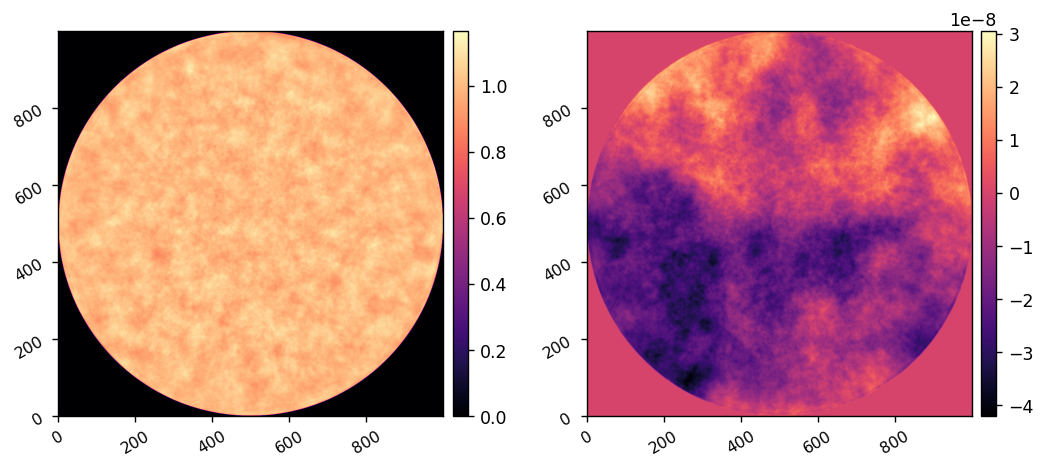

In [2]:
reload(fresnel)
I = fresnel.CORO()
I.use_opds = True

AMP, OPD = I.calc_pupil()
imshow2(AMP, OPD)

In [3]:
reload(fraunhofer)
M = fraunhofer.MODEL()

1.0
(952,) <class 'numpy.ndarray'>


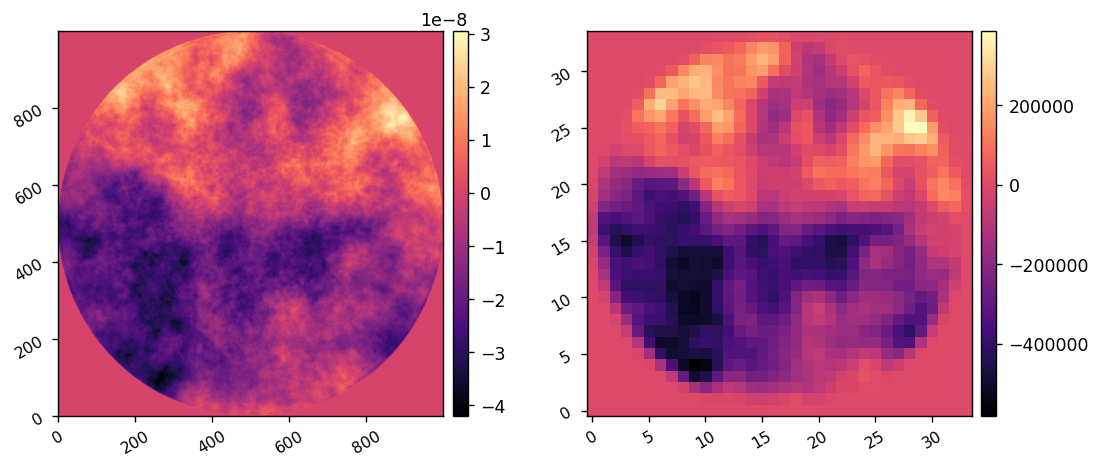

In [4]:
def val_and_grad(
    del_acts, 
    M, 
    OPD, 
    current_acts=np.zeros((34,34)) 
    ):
    del_acts = xp.array(del_acts)
    del_command = xp.zeros((M.Nact,M.Nact))
    del_command[M.dm_mask] = xp.array(del_acts[:M.Nacts//2])

    current_acts = xp.array(current_acts)

    dm1_command = current_acts + del_command
    dm1_mft = M.Mx@dm1_command@M.My
    dm1_surf_fft = M.inf_fun_fft * dm1_mft
    dm1_surf = xp.fft.fftshift(xp.fft.ifft2(xp.fft.ifftshift(dm1_surf_fft,))).real
    dm1_surf = utils.pad_or_crop(dm1_surf, M.npix)

    OPD = xp.array(OPD)
    opd_l2norm = OPD[M.APMASK].dot(OPD[M.APMASK])
    total_opd =  OPD + 2*dm1_surf
    J = total_opd[M.APMASK].dot(total_opd[M.APMASK]) / opd_l2norm
    print(J)

    masked_total = M.APMASK * total_opd
    dJ_dOPD = 2 * (masked_total) / opd_l2norm

    dJ_dS_DM1 = utils.pad_or_crop(dJ_dOPD, M.Nsurf)
    x2_bar = xp.fft.fftshift(xp.fft.fft2(xp.fft.ifftshift(dJ_dS_DM1)))
    x1_bar = x2_bar * M.inf_fun_fft.conj()
    dJ_dA1 = M.Mx_back@x1_bar@M.My_back / ( M.Nsurf * M.Nact * M.Nact )

    dJ_dA = dJ_dA1[M.dm_mask].real

    return ensure_np_array(J), ensure_np_array(dJ_dA)

del_acts = xp.zeros(M.Nacts//2)
J0, dJ_dA = val_and_grad(del_acts, M, OPD)
print(dJ_dA.shape, type(dJ_dA))

dm_grad = xp.zeros((M.Nact, M.Nact))
dm_grad[M.dm_mask] = xp.array(dJ_dA)
imshow2(OPD, dm_grad)

In [56]:
M.Nacts//2

952

1.0
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =          952     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.00000D+00    |proj g|=  5.82642D+05
55233197076223.586
0.5926998185300176

At iterate    1    f=  5.92700D-01    |proj g|=  4.55423D+05
0.023599192418289

At iterate    2    f=  2.35992D-02    |proj g|=  4.58340D+04
0.020803977363677846

At iterate    3    f=  2.08040D-02    |proj g|=  2.17971D+04
0.01819633998380522

At iterate    4    f=  1.81963D-02    |proj g|=  9.04144D+03
0.017714778231594175

At iterate    5    f=  1.77148D-02    |proj g|=  8.06524D+03
0.017477207224850858

At iterate    6    f=  1.74772D-02    |proj g|=  4.92911D+03
0.017386299452214236

At iterate    7    f=  1.73863D-02    |proj g|=  3.14484D+03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = n

 This problem is unconstrained.


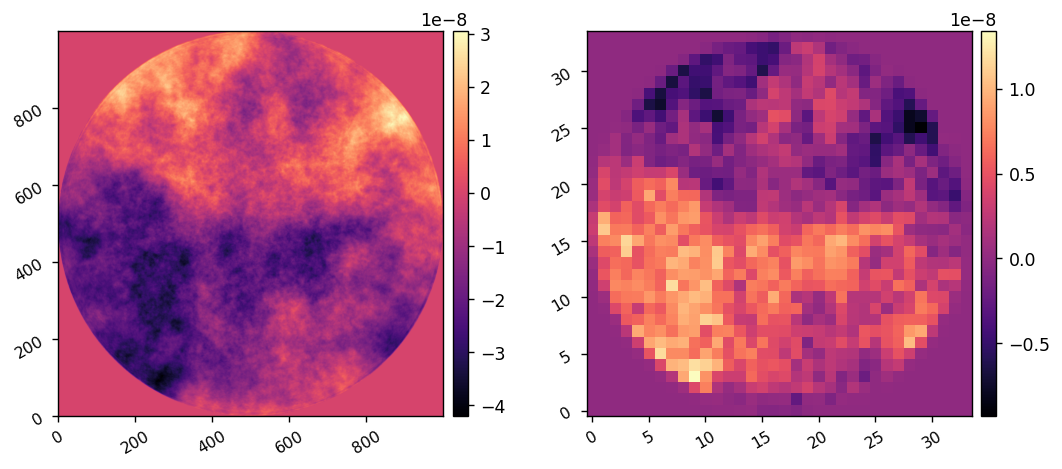

In [5]:
bfgs_tol = 1e-4
options = {
    'disp':True, 
    # 'maxiter':30,
    # 'maxls':100, # default is 20
    # 'ftol':1e-6, 
    # 'gtol':1e-6,
}
OPD = ensure_np_array(OPD)
del_acts0 = np.zeros(M.Nacts//2)
res = minimize(
    val_and_grad, 
    jac=True, 
    x0=del_acts0, 
    args=(M, OPD),
    method='L-BFGS-B',
    tol=bfgs_tol,
    options=options,
)

min_command = xp.zeros((M.Nact, M.Nact))
min_command[M.dm_mask] = xp.array(res.x)
imshow2(OPD, min_command,)

In [6]:
utils.save_fits('dm1_flat_command.fits', min_command)

Saved data to:  dm1_flat_command.fits
